# Datashading Sentinel-2 raster satellite imagery

Datashader is fundamentally a rasterizing library, turning data into rasters (image-like arrays), but it is also useful for already-rasterized data like satellite imagery.  For raster data, datashader uses the separate [xarray](http://xarray.pydata.org/) library to re-render the data to whatever new bounding box and resolution the user requests, and the rest of the datashader pipeline can then be used to visualize and analyze the data.  This demo shows how to work with a set of raster satellite data, generating images as needed and overlaying them on geographic coordinates using [HoloViews](http://holoviews.org), [GeoViews](http://geo.holoviews.org), and [Bokeh](http://bokeh.pydata.org).


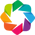

In [1]:
import numpy as np
import xarray as xr
import holoviews as hv
import geoviews as gv
import datashader as ds
import cartopy.crs as ccrs

from holoviews.operation.datashader import regrid, shade
from bokeh.tile_providers import STAMEN_TONER

hv.extension('bokeh', width=80)

### Load LandSat Data 

LandSat data is measured in different frequency bands, revealing different types of information:

In [2]:
import pandas as pd
band_info = pd.DataFrame([
        ("01", "Coastal Aerosol",       " 20",    0.443,  "60",),
        ("02", "Blue",                  " 65",    0.490,  "10",),
        ("03", "Green",                 " 35",    0.560,  "10",),
        ("04", "Red",                   " 30",    0.665,  "10",),
        ("05", "Vegetation Red Edge",   " 15",    0.705,  "20",),
        ("06", "Vegetation Red Edge",   " 15",    0.740,  "20",),
        ("07", "Vegetation Red Edge",   " 20",    0.783,  "20",),
        ("08", "NIR",                   "115",    0.842,  "10",),
        ("8A", "Narrow NIR",            " 20",    0.865,  "20",),
        ("09", "Water vapour",          " 20",    0.945,  "60",),
        ("10", "SWIR - Cirrus",         " 20",    1.375,  "60",),
        ("11", "SWIR",                  " 90",    1.610,  "20",),
        ("12", "SWIR",                  "180",    2.190,  "20",)],
    columns=['Band', 'Name', 'Bandwidth (µm)', 'Nominal Wavelength (µm)', 'Resolution (m)'])
band_info

Band                 Name Bandwidth (µm)  Nominal Wavelength (µm)  \
0    01      Coastal Aerosol             20                    0.443   
1    02                 Blue             65                    0.490   
2    03                Green             35                    0.560   
3    04                  Red             30                    0.665   
4    05  Vegetation Red Edge             15                    0.705   
5    06  Vegetation Red Edge             15                    0.740   
6    07  Vegetation Red Edge             20                    0.783   
7    08                  NIR            115                    0.842   
8    8A           Narrow NIR             20                    0.865   
9    09         Water vapour             20                    0.945   
10   10        SWIR - Cirrus             20                    1.375   
11   11                 SWIR             90                    1.610   
12   12                 SWIR            180                    2.190   

   Resolution (m)  
0              60  
1              10  
2              10  
3              10  
4              20  
5              20  
6              20  
7              10  
8              20  
9              60  
10             60  
11             20  
12             20

In [3]:
file_path = 'C:/Users/Administrator/Documents/S2A_MSIL1C_20170531T100031_N0205_R122_T33TTG_20170531T100536.SAFE/GRANULE/L1C_T33TTG_A010129_20170531T100536/IMG_DATA/T33TTG_20170531T100031_B%s.jp2'
bands = list(band_info.Band)
bands = [xr.open_rasterio(file_path%band).load()[0] for band in bands]

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
def deepcopy_xarr(xarr):
    from copy import deepcopy
    """
    Deepcopy for xarray that makes sure coords and attrs
    are properly deepcopied.
    With normal copy method from xarray, when i mutated
    xarr.coords[coord].data it would also mutate in the copy
    and vice versa.
    Parameters
    ----------
    xarr: DateArray

    Returns
    -------
    xcopy: DateArray
        Deep copy of xarr
    """
    xcopy = xarr.copy()

    for dim in xcopy.coords:
        xcopy.coords[dim].data = np.copy(xcopy.coords[dim].data)
    xcopy.attrs = deepcopy(xcopy.attrs)
    for attr in xcopy.attrs:
        xcopy.attrs[attr] = deepcopy(xcopy.attrs[attr])
    return xcopy
bandsOrig = [deepcopy_xarr(bands[i]) for i in range(len(bands))]

In [5]:
from pyproj import Proj, transform
inProj = Proj(init=bandsOrig[0].crs[6:])
outProj = Proj(init='epsg:3785')

for i in range(len(bands)):
    
    xDummy = np.array(bandsOrig[i].coords['x'])
    yDummy = np.array(bandsOrig[i].coords['y'])

    xC, yC = transform(inProj,outProj, xDummy, yDummy)
    bands[i].coords['x']=xC
    bands[i].coords['y']=yC


# scale the arrays to 60 m resolution for efficiency reason
def scaling(arr):
    if arr.size == 10980**2:
        scale = 6
    if arr.size == (10980/2)**2:
        scale = 3
    if arr.size == (10980/6)**2:
        scale = 1
    out = arr[::scale, ::scale]
    return out

scaledBands = [scaling(bands[i]) for i in range(len(bands))]

## Rendering Sentinel-2 data as images

The bands measured by Sentinel-2 include wavelengths covering the visible spectrum, but also other ranges, and so it's possible to visualize this data in many different ways, in both true color (using the visible spectrum directly) or false color (usually showing other bands).  Some examples are shown in the sections below.

### Just the Blue Band

Using datashader's default histogram-equalized colormapping, the full range of data is visible in the plot:

In [ ]:
tiles.crs.proj4_init, outProj.srs

In [6]:
%opts Overlay [width=600 height=600]
tiles = gv.WMTS(STAMEN_TONER)
tiles * shade(regrid(hv.Image(bands[1])), cmap=['blue', 'white']).redim(x='Longitude', y='Latitude')

:DynamicMap   []

You will usually want to zoom in, which will re-rasterize the image if you are in a live notebook, and then re-equalize the colormap to show all the detail available.  If you are on a static copy of the notebook, only the original resolution at which the image was rendered will be available, but zooming will still update the map tiles to whatever resolution is requested.

The plots below use a different type of colormap processing, implemented as a custom transfer function:

In [36]:
from datashader.utils import ngjit
nodata= 1

@ngjit
def normalize_data(agg):
    out = np.zeros_like(agg)
    x_min = agg.min()
    x_max = agg.max()
    range_x = x_max - x_min
    norm = (agg - x_min) / range_x
    out = norm * 255.0
    return out

def combine_bands(r, g, b):
    xs, ys = r['x'], r['y']
    r, g, b = [ds.utils.orient_array(img) for img in (r, g, b)]
    a = (np.where(np.logical_or(np.isnan(r),r<=nodata),0,255)).astype(np.uint8)    
    r = (normalize_data(r)).astype(np.uint8)
    g = (normalize_data(g)).astype(np.uint8)
    b = (normalize_data(b)).astype(np.uint8)
    print(g)
    col, rows = r.shape
    return hv.RGB((xs, ys[::-1], r, g, b, a), vdims=list('RGBA'))

In [8]:
a = ds.utils.orient_array(bands[1])
print(a)

[[961 956 958 ..., 862 865 856]
 [954 950 969 ..., 861 863 855]
 [958 962 946 ..., 855 860 849]
 ..., 
 [974 951 961 ..., 835 839 814]
 [975 962 963 ..., 783 812 828]
 [970 959 956 ..., 807 835 823]]


from datashader.utils import ngjit
nodata= 1

@ngjit
def normalize_fabio(agg):
    out = np.zeros_like(agg)
    min_val = 0
    max_val = 10000
    col, rows = agg.shape
    out = agg*255/max_val
    return out

def array_normalisation(image_array,low=0,high=255):
    """To normalise an input array."""
    
    image_array_maxValue  = image_array.max()
    image_array_minValue  = image_array.min()
    image_array_norm = float(low) + (image_array - image_array_minValue) * (float(high) - float(low)) / (image_array_maxValue-image_array_minValue)   
    
    return image_array_norm

def imageStretch(image_array, low_border, high_border):
    """Linear Stretching between Min and Max Values."""
    
    image_array = image_array.astype(float)
    image_array_clip = np.clip(image_array, low_border, high_border)
    image_array_new = array_normalisation(image_array_clip)
    image_array_new_int = image_array_new.astype(int)
    
    return image_array_new_int

def combine_bands(r, g, b, lim):
    xs, ys = r['x'], r['y']
    #r, g, b = [ds.utils.orient_array(img) for img in (r, g, b)]
    #a = (np.where(np.logical_or(np.isnan(r),r<=nodata),0,255)).astype(np.uint8)    
    r = (imageStretch(r, 0, lim)).astype(np.uint8)
    g = (imageStretch(g, 0, lim)).astype(np.uint8)
    b = (imageStretch(b, 0, lim)).astype(np.uint8)
    col, rows = r.shape
    return hv.RGB((xs, ys[::-1], r, g, b, a), vdims=list('RGBA'))

### True Color

Mapping the Red, Green, and Blue bands to the R, G, and B channels of an image reconstructs the image as it would appear to an ordinary camera from that viewpoint:

In [34]:
np.clip(bands[2], 0, 2e4), np.max(bands[2])

(<xarray.DataArray (y: 10980, x: 10980)>
 array([[ 608.,  612.,  611., ...,  755.,  773.,  777.],
        [ 611.,  609.,  609., ...,  710.,  744.,  766.],
        [ 612.,  616.,  606., ...,  827.,  757.,  754.],
        ..., 
        [ 541.,  553.,  537., ...,  744.,  727.,  716.],
        [ 538.,  546.,  538., ...,  737.,  726.,  726.],
        [ 545.,  550.,  551., ...,  731.,  711.,  711.]])
 Coordinates:
     band     int32 1
   * y        (y) float64 5.22e+06 5.22e+06 5.22e+06 5.22e+06 5.22e+06 ...
   * x        (x) float64 1.264e+06 1.264e+06 1.264e+06 1.264e+06 1.264e+06 ...,
 <xarray.DataArray ()>
 array(20115, dtype=uint16)
 Coordinates:
     band     int32 1)

In [38]:
lim = 5e3
true_color = combine_bands(np.clip(bands[3], 0, lim),np.clip(bands[2], 0, lim), np.clip(bands[1], 0, lim)).relabel("True Color (R=Red, G=Green, B=Blue)")
tiles * regrid(true_color)

[[27 28 28 ..., 37 36 36]
 [27 27 27 ..., 37 36 36]
 [27 28 27 ..., 37 37 36]
 ..., 
 [31 31 30 ..., 42 38 38]
 [31 31 31 ..., 36 37 39]
 [30 31 31 ..., 38 39 39]]


:DynamicMap   []

Again, the raster data will only refresh to a new resolution if you are running a live notebook, because that data is not actually present in the web page; it's held in a separate Python server.
 
### False Color

[Other combinations](https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/) highlight particular features of interest based on the different spectral properties of reflectances from various objects and surfaces, with full data redrawing on zooming if you have a live Python process:

In [45]:
'''%%opts RGB Curve [width=350 height=350 xaxis=None yaxis=None] {+framewise}

combos = pd.DataFrame([
    (4,3,2,"True color",""),
    (13,12,4,"Urban","False color"),
    (12,9,2,"Agriculture",""),
    (12,8,2,"Agriculture 11 8 2","RGB 11 8 2"),
    (12,8,3,"RGB 11 8 3",""),
    (13,12,2,"Geology","RGB 12 11 2"),
    (4,3,1,"Bathymetric","RGB 4 3 1"),
    (13,12,9,"Penetration","Atmospheric Penetration"),
    (13,8,4,"Shortwave Infrared","RGB 12 8 4"),
    (13,12,4,"SWIR","")],
    columns=['R', 'G', 'B', 'Name', 'Description']).set_index(["Name"])
combos

def combo(name):
    c=combos.loc[name]
    return regrid(combine_bands(bands[c.R-1],bands[c.G-1],bands[c.B-1])).relabel(name)

(combo("Urban") + combo("True color") + combo("Penetration") + combo("SWIR")).cols(2)'''

'%%opts RGB Curve [width=350 height=350 xaxis=None yaxis=None] {+framewise}\n\ncombos = pd.DataFrame([\n    (4,3,2,"True color",""),\n    (13,12,4,"Urban","False color"),\n    (12,9,2,"Agriculture",""),\n    (12,8,2,"Agriculture 11 8 2","RGB 11 8 2"),\n    (12,8,3,"RGB 11 8 3",""),\n    (13,12,2,"Geology","RGB 12 11 2"),\n    (4,3,1,"Bathymetric","RGB 4 3 1"),\n    (13,12,9,"Penetration","Atmospheric Penetration"),\n    (13,8,4,"Shortwave Infrared","RGB 12 8 4"),\n    (13,12,4,"SWIR","")],\n    columns=[\'R\', \'G\', \'B\', \'Name\', \'Description\']).set_index(["Name"])\ncombos\n\ndef combo(name):\n    c=combos.loc[name]\n    return regrid(combine_bands(bands[c.R-1],bands[c.G-1],bands[c.B-1])).relabel(name)\n\n(combo("Urban") + combo("True color") + combo("Penetration") + combo("SWIR")).cols(2)'

All the various ways of combining aggregates supported by [xarray](http://xarray.pydata.org) are available for these channels, making it simple to make your own custom visualizations highlighting any combination of bands that reveal something of interest.

### Revealing the spectrum

The above plots all map some of the measured data into the R,G,B channels of an image, showing all spatial locations but only a restricted set of wavelengths. Alternatively, you could sample across all the measured wavelength bands to show the full spectrum at any given location:

In [46]:
%%opts Curve [width=800 height=300 logx=True]

band_map = hv.HoloMap({i: hv.Image(band) for i, band in enumerate(bands)})

def spectrum(x, y):
    try: 
        spectrum_vals = band_map.sample(x=x, y=y)['z']
        point = gv.Points([(x, y)], crs=ccrs.GOOGLE_MERCATOR)
        point = gv.operation.project_points(point, projection=ccrs.PlateCarree())
        label = label = 'Lon: %.3f, Lat: %.3f' % tuple(point.array()[0])
    except:
        dummy = band_map[0]
        x, y = dummy.bounds.centroid()
        point = gv.Points([(x, y)], crs=ccrs.GOOGLE_MERCATOR)
        point = gv.operation.project_points(point, projection=ccrs.PlateCarree())
        spectrum_vals = band_map.sample(x=x, y=y)['z']
        #spectrum_vals = np.zeros(12)
        label = 'Lon: %.3f, Lat: %.3f' % tuple(point.array()[0])
    
    return hv.Curve((band_info['Nominal Wavelength (µm)'].values, spectrum_vals), label=label,
                    kdims=['Wavelength (µm)'], vdims=['Reflectance']).sort()

spectrum(x=None, y=None)

:Curve   [Wavelength (µm)]   (Reflectance)

We can now combine these two approaches to let you explore the full hyperspectral information at any location in the true-color image, updating the curve whenever you hover over an area of the image:

In [47]:
%%opts Curve RGB [width=450 height=450] Curve [logx=True]

tap = hv.streams.PointerXY(source=true_color)
spectrum_curve = hv.DynamicMap(spectrum, streams=[tap]).redim.range(Reflectance=(0, 10000))

tiles * regrid(true_color) + spectrum_curve

:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []

(Of course, just as for the raster data resolution, the plot on the right will update only in a live notebook session, because it needs to run Python code for each mouse pointer position.)

As you can see, even though datashader is not a GIS system, it can be a flexible, high-performance way to explore GIS data when combined with HoloViews, GeoViews, and Bokeh.